In [1]:
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 85.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

import keras
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
import pandas as pd
import numpy as np

In [4]:
df_train = pd.read_csv('TR_a.csv')
df_train=df_train.rename(columns={"gold_adj": "gold"})

df_dev = pd.read_csv('TD_a.csv')
df_dev=df_dev.rename(columns={"gold_adj": "gold"})

df_test = pd.read_csv('TE_a.csv')
df_test=df_test.rename(columns={"gold_adj": "gold"})

In [5]:
df_train['QA'] = df_train['Main_tweet'] + '[SEP]' + df_train['Reply_tweet']
df_dev['QA'] = df_dev['Main_tweet'] + '[SEP]' + df_dev['Reply_tweet']
df_test['QA'] = df_test['Main_tweet'] + '[SEP]' + df_test['Reply_tweet']


In [6]:
df_test['gold'].value_counts()

y     212
n     157
uk     80
py     49
pn     29
Name: gold, dtype: int64

In [7]:
y = pd.get_dummies(df_train.gold, prefix='gold')
y

,gold_n,gold_pn,gold_py,gold_uk,gold_y
0,0,0,0,0,1
1,0,0,0,0,1
2,1,0,0,0,0
3,1,0,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
3310,0,0,1,0,0
3311,1,0,0,0,0
3312,1,0,0,0,0
3313,0,0,0,1,0


In [8]:
y_dev = pd.get_dummies(df_dev.gold, prefix='gold')
y_dev

,gold_n,gold_pn,gold_py,gold_uk,gold_y
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
595,1,0,0,0,0
596,0,0,1,0,0
597,0,0,0,1,0
598,0,0,1,0,0


Roberta Init

In [9]:
# Changed to roberta

bert_preprocess = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1", trainable=True)
bert_encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1", trainable=True)

In [10]:
# RoBerta layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # Textual input layer
preprocessed_text = bert_preprocess(text_input) # The preprocessing of text
outputs = bert_encoder(preprocessed_text) # Encoded o/p

# Neural network layers
# l = tf.keras.layers.Dense(50, activation='sigmoid', name="output")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(6, activation='softmax', name="soft_output")(l)

# # adding drop out layer
# l = tf.keras.layers.Dropout(0.2, name="dropout")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(5, activation='softmax', name="soft_output")(l)

#use this if without dropout, instead of the two layers above
l = tf.keras.layers.Dense(5, activation='softmax', name="soft_output")(outputs['pooled_output'])

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [12]:
import keras

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.learning_rate # I use ._decayed_lr method instead of .lr
    return lr


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.01, restore_best_weights=True)

initial_learning_rate = 0.00002
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

lr_metric = get_lr_metric(optimizer)

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      lr_metric
]

# optimizer.learning_rate.assign(0.00002)
model.compile(optimizer=optimizer,
              loss='CategoricalCrossentropy',
              metrics=METRICS)

In [13]:
df_fqia = pd.read_csv('https://raw.githubusercontent.com/friendsQIA/Friends_QIA/main/Data/Friends_data/Final_QA_datasets/qa_data_train.csv', sep='\t')

# main corpus
df_twitter=pd.read_csv('TR_a.csv')
df_twitter=df_twitter.rename(columns={"gold_adj": "gold"})


In [14]:
df_fqia.columns

Index(['Unnamed: 0', 'Season', 'Episode', 'Category', 'Q_person', 'A_person',
       'Q_original', 'A_original', 'Q_modified', 'A_modified', 'Annotation_1',
       'Annotation_2', 'Annotation_3', 'Goldstandard'],
      dtype='object')

In [15]:
# blend corpus
df_fqia['QA'] = df_fqia['Q_modified'] + '[SEP]' + df_fqia['A_modified']
df_fqia = df_fqia[['QA','Goldstandard']].copy()


df_fqia['Goldstandard'] = df_fqia['Goldstandard'].replace(1, 'y')
df_fqia['Goldstandard'] = df_fqia['Goldstandard'].replace(2, 'n')
df_fqia['Goldstandard'] = df_fqia['Goldstandard'].replace(3, 'py')
df_fqia['Goldstandard'] = df_fqia['Goldstandard'].replace(4, 'uk')
df_fqia['Goldstandard'] = df_fqia['Goldstandard'].replace(5, 'uk')
df_fqia['Goldstandard'] = df_fqia['Goldstandard'].replace(6, 'uk')

df_fqia = df_fqia.rename(columns={"Goldstandard": "gold"})
df_fqia['corpus_type'] = 'fqia'

# main corpus
df_twitter['QA'] = df_twitter['Main_tweet'] + '[SEP]' + df_twitter['Reply_tweet']
df_twitter = df_twitter[['QA','gold']].copy()
df_twitter['corpus_type'] = 'twitter'

In [18]:
epochs = 200
val_loss = 100
patience = 0
alpha = 0.8
corpus_frac = 1 # initially
for e in range(epochs):

  df_train = pd.concat([df_twitter, df_fqia.sample(frac = corpus_frac)])
  df_train = df_train.sample(frac = 1)
  y_train = pd.get_dummies(df_train.gold, prefix='gold')
  print(df_train.shape)
  print(y_train.shape)

  # shortening blending corpus for quick sanity results
  # df_train = df_train.iloc[0:100]
  # y_train = y_train.iloc[0:100]
  # df_dev = df_dev.iloc[0:100]
  # y_dev = y_dev.iloc[0:100]

  corpus_frac = alpha * corpus_frac

  model.fit(df_train['QA'], y_train, epochs=1, batch_size=16, callbacks=[callback], validation_data = (df_dev['QA'], y_dev))
  if model.history.history['val_loss'][0] - val_loss <= 0.01:
    val_loss = model.history.history['val_loss'][0]
    saved_model = model
    patience = 0
  else:
    patience +=1
  if patience == 3:
    print('breaking now.....')
    break
  print('patience:',patience)
  print('epoch:',e)

(7686, 3)
(7686, 5)
481/481 [==============================] - 593s 1s/step - loss: 1.0199 - accuracy: 0.5693 - precision: 0.7041 - recall: 0.3820 - lr: 2.0000e-05 - val_loss: 1.0039 - val_accuracy: 0.5883 - val_precision: 0.7493 - val_recall: 0.4333 - val_lr: 2.0000e-05
patience: 0
epoch: 0
(6812, 3)
(6812, 5)
426/426 [==============================] - 513s 1s/step - loss: 0.7640 - accuracy: 0.7043 - precision: 0.7865 - recall: 0.6120 - lr: 2.0000e-05 - val_loss: 0.9895 - val_accuracy: 0.6000 - val_precision: 0.6982 - val_recall: 0.5050 - val_lr: 2.0000e-05
patience: 0
epoch: 1
(6112, 3)
(6112, 5)
382/382 [==============================] - 453s 1s/step - loss: 0.5982 - accuracy: 0.7808 - precision: 0.8326 - recall: 0.7276 - lr: 2.0000e-05 - val_loss: 1.0746 - val_accuracy: 0.6150 - val_precision: 0.6621 - val_recall: 0.5583 - val_lr: 2.0000e-05
patience: 1
epoch: 2
(5553, 3)
(5553, 5)
348/348 [==============================] - 416s 1s/step - loss: 0.4129 - accuracy: 0.8543 - precision

In [19]:
# epochs = 3
# val_loss = 100
# patience = 0
# for e in epochs:
#   model.fit(df_train['QA'], y, epochs=1, batch_size=16, callbacks=[callback], validation_data = (df_dev['QA'], y_dev))
#   if model.history.history['val_loss'][0] < val_loss:
#     val_loss = model.history.history['val_loss'][0]
#     saved_model = model
#   else:
#     patience +=1
#   if patience == 5:
#     break

Dev set

In [20]:
y_dev = pd.get_dummies(df_dev.gold, prefix = 'gold')
print(saved_model.evaluate(df_dev['QA'], y_dev))
y_predicted = saved_model.predict(df_dev['QA'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n',
                                       'gold_pn',
                                       'gold_py',
                                       'gold_uk',
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

dev_gtruths = [np.where(r==1)[0][0] for r in y_dev.to_numpy()]
dev_gtruths = pd.DataFrame(dev_gtruths, columns=['gold'])

dev_gtruths['gold'] = dev_gtruths['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('DEV')
from sklearn.metrics import classification_report
print(classification_report(y_true = dev_gtruths['gold'], y_pred = pred_results['gold']))

19/19 [==============================] - 17s 887ms/step - loss: 1.4824 - accuracy: 0.6167 - precision: 0.6423 - recall: 0.6017 - lr: 2.0000e-05
[1.4824025630950928, 0.6166666746139526, 0.6423487663269043, 0.6016666889190674, 2.000000313273631e-05]
19/19 [==============================] - 16s 843ms/step
DEV
              precision    recall  f1-score   support

           n       0.61      0.66      0.63       166
          pn       0.23      0.16      0.19        19
          py       0.49      0.43      0.46        61
          uk       0.58      0.54      0.56       113
           y       0.69      0.71      0.70       241

    accuracy                           0.62       600
   macro avg       0.52      0.50      0.51       600
weighted avg       0.61      0.62      0.61       600



Test Set

In [21]:
df_test= df_test.rename(columns={"gold_adj": "gold"})
y_test = pd.get_dummies(df_test.gold, prefix = 'gold')
print(saved_model.evaluate(df_test['QA'], y_test))
y_predicted = saved_model.predict(df_test['QA'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n',
                                       'gold_pn',
                                       'gold_py',
                                       'gold_uk',
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

test_gtruths = [np.where(r==1)[0][0] for r in y_test.to_numpy()]
test_gtruths = pd.DataFrame(test_gtruths, columns=['gold'])

test_gtruths['gold'] = test_gtruths['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('TEST')
from sklearn.metrics import classification_report
print(classification_report(y_true = test_gtruths['gold'], y_pred = pred_results['gold']))

17/17 [==============================] - 14s 803ms/step - loss: 1.5624 - accuracy: 0.6528 - precision: 0.6687 - recall: 0.6395 - lr: 2.0000e-05
[1.56243097782135, 0.6527514457702637, 0.6686508059501648, 0.6394686698913574, 2.000000313273631e-05]
17/17 [==============================] - 13s 787ms/step
TEST
              precision    recall  f1-score   support

           n       0.65      0.77      0.71       157
          pn       0.20      0.03      0.06        29
          py       0.50      0.29      0.36        49
          uk       0.58      0.55      0.56        80
           y       0.71      0.77      0.74       212

    accuracy                           0.65       527
   macro avg       0.53      0.48      0.49       527
weighted avg       0.62      0.65      0.63       527



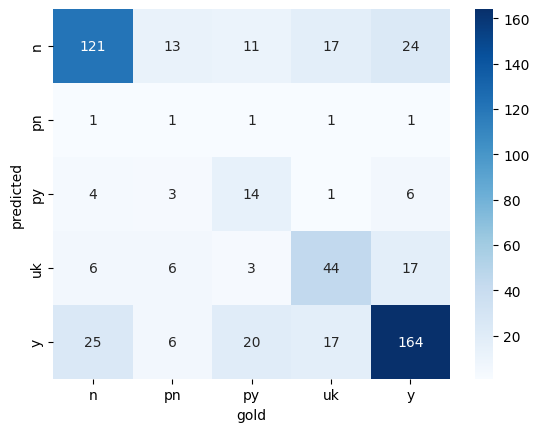

gold         n  pn  py  uk    y
predicted                      
n          121  13  11  17   24
pn           1   1   1   1    1
py           4   3  14   1    6
uk           6   6   3  44   17
y           25   6  20  17  164


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(pred_results['gold'],test_gtruths['gold'],rownames=['predicted'], colnames=['gold'])

sns.heatmap(confusion_matrix,annot=True,cmap='Blues', fmt='g')
plt.show()
print(confusion_matrix)

In [23]:
pred_results = pred_results.rename(columns={"gold": "predict"})
pred_results['Main_Tweet_ID'] = df_test['Main_Tweet_ID']
pred_results['Reply_id'] = df_test['Reply_id']

In [24]:
pred_results['predict'].value_counts()

y     232
n     186
uk     76
py     28
pn      5
Name: predict, dtype: int64

In [25]:
pred_results.to_csv('A_friends_blend.csv')